## Molecular evolution of the influenza virus

The text file **influenza_HA_dna_sequences.fasta** contains the complete DNA sequence of the hemagglutinin (HA) gene of 841 influenza viruses samples collected between 1968 and 2005. Hemagglutinin is a protein that mediates the virus entry into cells and is a target of antibodies produced by the human host that neutralize the virus. To avoid recognition by the immune system, the virus changes its hemagglitinin gene sequence over time. Analyze these sequence data to answer the following questions:

* How do mutations accumulate as a function of time? That is, how does the number of single nucleotide differences between the first sample (A/Aichi/2/1968) and samples from a given year vary as a function of time? Make the graph.

* What fraction of the HA gene has changed as a function of time?

* What is the genetic variation (average pairwise distance) between the strains from the same year?

* How long would we have to wait for the population to accumulate the same number of genetic differences that typically separate co-circulating strains?

In [2]:
from Bio import SeqIO
from Bio.Align import PairwiseAligner
import sys
import os
sys.path.append(os.path.join(os.path.dirname(os.getcwd()), 'population_dynamics'))
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import re
from individual import Individual

In [4]:
# Load collection of sequences
fasta_path = os.path.join(os.getcwd(),"influenza_HA_dna_sequences.fasta")
sequences = {s.id: s.seq for s in SeqIO.parse(fasta_path, 'fasta')}

In [3]:
# Nicely print first or last 5 elements of sequences
# for i, (k, v) in enumerate(reversed(sequences.items())):
for i, (k, v) in enumerate(sequences.items()):
    print(f"{k}: {v}")
    if i == 5: break

A/Aichi/2/1968: AAGACCATCATTGCTTTGAGCTACATTTTCTGTCTGGCTATCGGCCAAGACCTTCCAGGAAATGACAACAGCACAGCAACGCTGTGCCTGGGACATCATGCGGTGCCAAACGGAACACTAGTGAAAACAATCACAGATGATCAGATTGAAGTGACTAATGCTACTGAGCTAGTTCAGAGCTCCTCAACGGGGAAAATATGCAACAATCCTCATCGAATCCTTGATGGAATAGACTGCACACTGATAGATGCTCTATTGGGGGACCCTCATTGTGATGTTTTTCAAAATGAGACATGGGACCTTTTCGTTGAACGCAGCAAAGCTTTCAGCAACTGTTACCCTTATGATGTGCCAGATTATGCCTCCCTTAGGTCACTAGTTGCCTCGTCAGGCACTCTGGAGTTTATCACTGAGGGTTTCACTTGGACTGGGGTCACTCAGAATGGGGGAAGCAATGCTTGCAAAAGGGGACCTAGTAGCGGTTTTTTCAGTAGACTGAACTGGTTGACCAAATCAGGAAGCACATATCCAGTGCTGAACGTGACTATGCCAAACAATGACAATTTTGACAAACTATACATTTGGGGGGTTCACCACCCGAGCACGAACCAAGAACAAACCAGCCTGTATGTTCAAGCATCAGGGAGAGTCACAGTCTCTACCAGGAGAAGCCAGCAAACTATAATCCCGAATATCGGGTCCAGACCCTGGGTAGGGGGTCTGTCTAGTAGAATAAGCATCTATTGGACAATAGTTAAGCCGGGAGACGTACTGGTAATTAATAGTAATGGGAACCTAATCGCTCCTCGGGGTTATTTCAAAATGCGCACTGGGAAAAGCTCAATAATGAGGTCAGATGCACCTATTGATACCTGTATTTCTGAATGCATCACTCCAAATGGAAGCATTCCCAATGACAAGCCCTTTCAAAACGTAAACAAGATCACATATGGAGCATGCCCCAAGTATGTTAAGCAAAACACC

In [4]:
# Quickly check if all sequences have the same length
lengths = set(len(v) for v in sequences.values())
if len(lengths) == 1:
    print(f"All sequences have length {lengths}")
else:
    print(f"Sequences have different lengths: {lengths}")
genome_length = lengths.pop()

All sequences have length {1694}


In [5]:
# Couple entries missing year information
years = [re.search(r"\d{4}$", k) for k in sequences.keys()]  # retain order of sequences
years = [int(year.group(0)) if year is not None else -1 for year in years]
print(years)

[1968, 1969, 1970, 1976, 1968, 1968, 1978, 1976, 1968, 1968, 1968, 1970, 1974, 1969, 1970, 1969, 1977, 1975, 1968, 1970, 1989, 1988, 2004, 1999, 2004, 2003, 2005, 2006, 2003, 2005, 2003, 2005, 2003, 2005, 2003, 2005, 2005, 2005, 2005, 2006, 1986, 1999, 2002, 2003, 2004, 2005, 2006, 2006, 1992, 1992, 1992, 1999, 2003, 2004, 2005, 2006, 2005, 2006, 1968, 1971, 1977, 1980, 1981, 1986, 1990, 1972, 1974, 1972, 1972, 1974, 1976, 1976, 1976, 1976, 1972, 1986, 1978, 1985, 1988, 1976, 1978, 1978, 1978, 1978, 1985, 1990, 1995, 1985, 1971, 1973, 1980, 1986, 1988, 2003, 1998, 1983, 1980, 1985, 1986, 1988, 1990, 1999, 1986, 1985, 1990, 1988, 1980, 2000, 2002, 2003, 2005, 2006, 2004, -1, 2006, 2006, 2006, 2003, 1988, -1, 1977, 2002, 2003, 2005, 2006, 2005, 2006, 2005, 2006, 2003, 2003]


In [ ]:
print(type(sequences["A/Aichi/2/1968"]))
print(sequences["A/Aichi/2/1968"])  # Seq is an iterable?

<class 'Bio.Seq.Seq'>
AAGACCATCATTGCTTTGAGCTACATTTTCTGTCTGGCTATCGGCCAAGACCTTCCAGGAAATGACAACAGCACAGCAACGCTGTGCCTGGGACATCATGCGGTGCCAAACGGAACACTAGTGAAAACAATCACAGATGATCAGATTGAAGTGACTAATGCTACTGAGCTAGTTCAGAGCTCCTCAACGGGGAAAATATGCAACAATCCTCATCGAATCCTTGATGGAATAGACTGCACACTGATAGATGCTCTATTGGGGGACCCTCATTGTGATGTTTTTCAAAATGAGACATGGGACCTTTTCGTTGAACGCAGCAAAGCTTTCAGCAACTGTTACCCTTATGATGTGCCAGATTATGCCTCCCTTAGGTCACTAGTTGCCTCGTCAGGCACTCTGGAGTTTATCACTGAGGGTTTCACTTGGACTGGGGTCACTCAGAATGGGGGAAGCAATGCTTGCAAAAGGGGACCTAGTAGCGGTTTTTTCAGTAGACTGAACTGGTTGACCAAATCAGGAAGCACATATCCAGTGCTGAACGTGACTATGCCAAACAATGACAATTTTGACAAACTATACATTTGGGGGGTTCACCACCCGAGCACGAACCAAGAACAAACCAGCCTGTATGTTCAAGCATCAGGGAGAGTCACAGTCTCTACCAGGAGAAGCCAGCAAACTATAATCCCGAATATCGGGTCCAGACCCTGGGTAGGGGGTCTGTCTAGTAGAATAAGCATCTATTGGACAATAGTTAAGCCGGGAGACGTACTGGTAATTAATAGTAATGGGAACCTAATCGCTCCTCGGGGTTATTTCAAAATGCGCACTGGGAAAAGCTCAATAATGAGGTCAGATGCACCTATTGATACCTGTATTTCTGAATGCATCACTCCAAATGGAAGCATTCCCAATGACAAGCCCTTTCAAAACGTAAACAAGATCACATATGGAGCATGCCCCAAGTATGTTAAGCAA

In [7]:
# Assumed that HA DNA is aligned but align and iterate to find SNPs
def align_and_find_snps(seq1, seq2, alignment_length):
    aligner = PairwiseAligner()
    alignments = aligner.align(seq1[:alignment_length], seq2[:alignment_length])  # Align specified base pairs
    best_alignment = alignments[0]
    snps = []
    for i in range(len(seq1[:alignment_length])):
        if seq1[i] != seq2[i]:
            snps.append((i, seq1[i], seq2[i])) # Position, base1, base2
    return snps, best_alignment

In [ ]:
# Find number of SNP differences between first sample and all other samples as a function of time
first_sequence = sequences["A/Aichi/2/1968"]
snp_differences = np.zeros(len(sequences))
years = np.zeros(len(sequences))
seq_strings = []  # need to construct list and convert after to fixed-width string ndarray
for i, (k, v) in enumerate(sequences.items()):
    if k == "A/Aichi/2/1968":
        years[i] = 1968
        snp_differences[i] = 0
        seq_strings.append(str(v))
        continue
    year = re.search(r"\d{4}$", k)
    if year is not None:
        years[i] = int(year.group(0))
    else:
        years[i] = -1
    snps, _ = align_and_find_snps(first_sequence, v, genome_length)  # Takes a second for alignment
    snp_differences[i] = len(snps)
    seq_strings.append(str(v))

# Vectors >>> dictionaries
seq_strings = np.array(seq_strings, dtype=f"<U{genome_length}")

In [9]:
def get_best_fit_boostrappedCI(plot_years, plot_snps):
    # linear regression
    slope, intercept, r_value, p_value, std_err = stats.linregress(plot_years, plot_snps)

    # Create line of best fit for plot
    line = slope * plot_years + intercept

    # Bootstrap method to estimate confidence interval
    n_bootstrap = 10000
    bootstrap_slopes = np.zeros(n_bootstrap)
    bootstrap_intercepts = np.zeros(n_bootstrap)

    # Perform bootstrap resampling creating fit for each sample
    for i in range(n_bootstrap):
        # Resample with replacement
        indices = np.random.randint(0, len(plot_years), len(plot_years))
        sample_years = plot_years[indices]
        sample_snps = plot_snps[indices]
        
        # Compute regression for each bootstrap sample
        boot_slope, boot_intercept, _, _, _ = stats.linregress(sample_years, sample_snps)
        bootstrap_slopes[i] = boot_slope
        bootstrap_intercepts[i] = boot_intercept

    # Compute confidence intervals for slope and intercept
    # slope_ci = np.percentile(bootstrap_slopes, [2.5, 97.5])
    # intercept_ci = np.percentile(bootstrap_intercepts, [2.5, 97.5])

    # Generate prediction intervals
    def generate_bootstrap_line(x):
        # Sample random slope and intercept from bootstrap results
        idx = np.random.randint(0, n_bootstrap)
        return bootstrap_slopes[idx] * x + bootstrap_intercepts[idx]

    # Generate multiple bootstrap lines
    n_lines = 200
    bootstrap_lines = np.array([generate_bootstrap_line(plot_years) for _ in range(n_lines)])

    # Compute envelope of bootstrap lines
    lower_envelope = np.percentile(bootstrap_lines, 2.5, axis=0)
    upper_envelope = np.percentile(bootstrap_lines, 97.5, axis=0)

    return line, r_value, lower_envelope, upper_envelope, slope

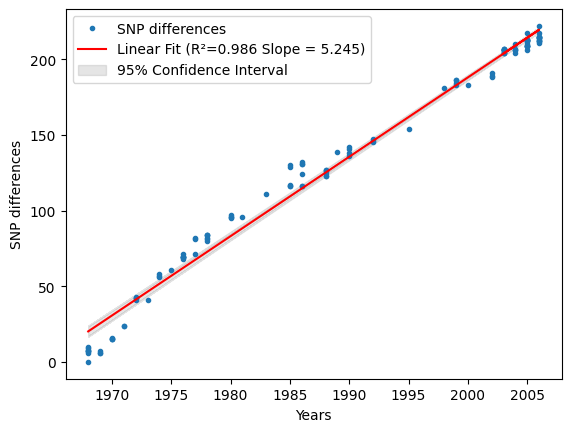

In [10]:
# Plot Years vs SNPs with boostrapped confidence interval
plot_years = years[years!=-1]
plot_snps = snp_differences[years!=-1]

# Get bootstrapped CI
line, r_value, lower_envelope, upper_envelope, main_slope = get_best_fit_boostrappedCI(plot_years, plot_snps)

plt.plot(plot_years, plot_snps, '.', label='SNP differences')
plt.xlabel("Years")
plt.ylabel("SNP differences")
plt.plot(plot_years, line, color='red', label=f'Linear Fit (R²={r_value**2:.3f} Slope = {main_slope:.3f})')
# Plot confidence interval
plt.fill_between(plot_years, 
                lower_envelope, 
                upper_envelope, 
                color='gray', 
                alpha=0.2, 
                label='95% Confidence Interval')
# add legend to upper left corner
plt.legend(loc='upper left')

Text(0.5, 1.0, 'Influenza HA Normalized SNP differences')

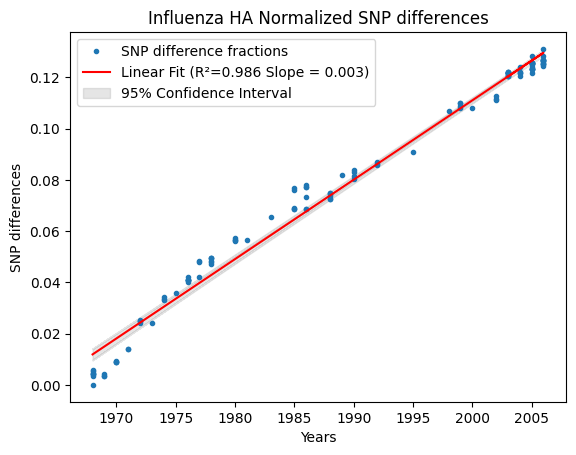

In [11]:
# Plot Years vs SNPs with boostrapped confidence interval
plot_years = years[years!=-1]
plot_snps = snp_differences[years!=-1]/genome_length

# Get bootstrapped CI
line, r_value, lower_envelope, upper_envelope, slope = get_best_fit_boostrappedCI(plot_years, plot_snps)

plt.plot(plot_years, plot_snps, '.', label='SNP difference fractions')
plt.xlabel("Years")
plt.ylabel("SNP differences")
plt.plot(plot_years, line, color='red', label=f'Linear Fit (R²={r_value**2:.3f} Slope = {slope:.3f})')
# Plot confidence interval
plt.fill_between(plot_years, 
                lower_envelope, 
                upper_envelope, 
                color='gray', 
                alpha=0.2, 
                label='95% Confidence Interval')
# add legend to upper left corner
plt.legend(loc='upper left')
plt.title("Influenza HA Normalized SNP differences")

Text(0.5, 1.0, 'Influenza HA SNP differences averaged per year')

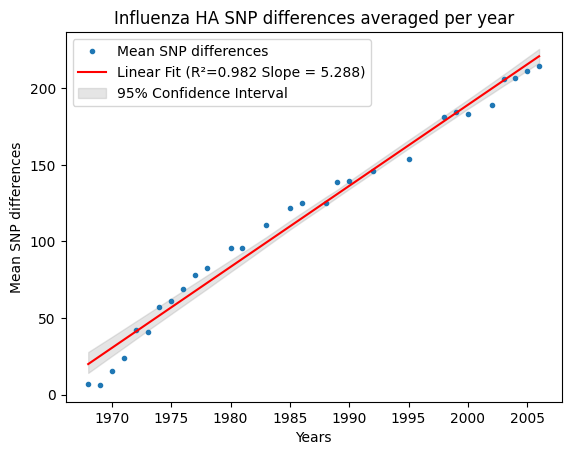

In [12]:
# Find the mean pairwise SNP differences between strains of the same year
plot_years = years[years!=-1]
plot_snps = snp_differences[years!=-1]
yearly_snps = {year: 0. for year in set(plot_years)}

for i, v in enumerate(plot_years):
    yearly_snps[v] = np.mean(plot_snps[plot_years==v])

plot_years, plot_snps = np.array(list(yearly_snps.keys())), np.array(list(yearly_snps.values()))

# Get bootstrapped CI
line, r_value, lower_envelope, upper_envelope, slope = get_best_fit_boostrappedCI(plot_years, plot_snps)

plt.plot(list(yearly_snps.keys()), list(yearly_snps.values()), '.', label='Mean SNP differences')
plt.plot(plot_years, line, color='red', label=f'Linear Fit (R²={r_value**2:.3f} Slope = {slope:.3f})')
# Plot confidence interval
plt.fill_between(plot_years, 
                lower_envelope, 
                upper_envelope, 
                color='gray', 
                alpha=0.2, 
                label='95% Confidence Interval')
# add legend to upper left corner
plt.xlabel("Years")
plt.ylabel("Mean SNP differences")
plt.legend(loc='upper left')
plt.title("Influenza HA SNP differences averaged per year")

Text(0.5, 1.0, 'Influenza HA mean Pairwise Distance in SNPs within Year')

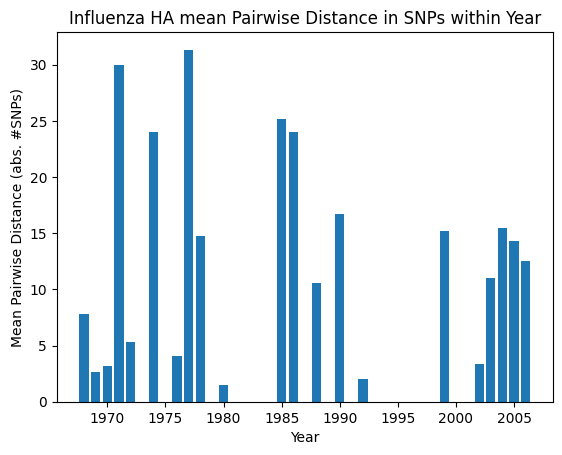

In [13]:
# Find mean pairwise distance of sequences in same year
plot_years = years[years!=-1]
plot_seqs = seq_strings[years!=-1]

mean_pairwise_dist = {year: 0 for year in set(plot_years)}

for y in mean_pairwise_dist.keys():
    year_logical = plot_years==y
    if np.sum(year_logical) <= 1:
        continue
    distances = Individual.calculate_genetic_distance(list(plot_seqs[plot_years==y]))
    mean_pairwise_dist[y] = np.mean(np.array([d for d in distances.values()]))  # np.mean doesn't like dict values
    
plt.bar(list(mean_pairwise_dist.keys()), list(mean_pairwise_dist.values()))
plt.xlabel("Year")
plt.ylabel("Mean Pairwise Distance (abs. #SNPs)")
plt.title("Influenza HA mean Pairwise Distance in SNPs within Year")

In [14]:
# Number of years to accumulate same distance which typically circulates strains
# Equivalent to ~mean(mean_pairwise_distance_over_years) / slope of best fit line
mean_pairwise_distance_over_time = np.array(list(mean_pairwise_dist.values()))
mean_pairwise_distance_over_time = np.mean(mean_pairwise_distance_over_time[mean_pairwise_distance_over_time!=0])

years_to_match_variation = mean_pairwise_distance_over_time/main_slope
months_to_match_variation = (years_to_match_variation % np.floor(years_to_match_variation)) * 12

print(f"The mean variation (pairwise distance) within year for the influenza HA is:\n"+
      f"{mean_pairwise_distance_over_time:0.0f} nucleotides, or {100*mean_pairwise_distance_over_time/genome_length:0.0f}%\n"+
      f"Using the slope of SNP/time of {main_slope:0.02f} nucleotides per year, it would take approximately "+
      f"{years_to_match_variation:0.0f} years, {months_to_match_variation:0.0f} months.")


The mean variation (pairwise distance) within year for the influenza HA is:
13 nucleotides, or 1%
Using the slope of SNP/time of 5.24 nucleotides per year, it would take approximately 2 years, 6 months.
